## <h1><center>Assignment 1: Classification With Convolutional Neural Networks</center></h1>




<center><img src="https://www.cs.cornell.edu/courses/cs4782/2025sp/slides/traffic_sign.jpeg"></center>



&nbsp;


---



**GOAL:** In this assignment you will be implementing different CNNs for traffic sign detection. You will also implement a few optimization techniques along the way such as dropout and batch normalization.

&nbsp;

**WHAT YOU'LL SUBMIT:** Your submission to Gradescope includes:

1.   Files `submission.py` and `resnet_preds.csv` uploaded to [***Coding Assignment 1***](https://www.gradescope.com/courses/1245650).
2.   A PDF containing responses to questions in the notebook, uploaded to [***Coding Assignment 1 Written Responses***](https://www.gradescope.com/courses/1245650).

*More on how you are expected to access, modify and save these files as you follow along the instructions in the notebook.*

&nbsp;

**DO's:**

1.   **Running on GPU: Before you begin make sure to click on the runtime option and change your runtime type to the T4 GPU (this should make your training faster)**. (Note: If you would like to save GPU time, note that much of the coding and debugging can be done on the CPU. Then, you can switch to the GPU for training.)
2.   You will need to write code in the `## TODO` sections of `submission.py`.
3.   Remember to execute all code cells sequentially, not just those you’ve edited, to ensure your code runs properly.
4.   Please cite any external sources you use to complete this assignment in your written responses.

&nbsp;

**DONT's:**


1.   DO NOT change the names of any provided functions, classes, or variables within the existing code cells, as this will interfere with grading.
2.   DO NOT delete any provided code/imports.

&nbsp;

***NOTE:***
    
*You can resubmit your work as many times as necessary before the submission deadline. If you experience difficulty or have questions about this exercise, use the Ed discussion board to engage with your peers or seek assistance from the instructor.*




In [139]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

from google.colab import drive
from PIL import Image
from matplotlib import cm

import xml.etree.ElementTree as ET

import json
import os
import pickle
import sys

PyTorch is one of the most popular deep learning frameworks, and we will use PyTorch for all of the assignments this semester.
If this is your first time using PyTorch, [here](https://pytorch.org/tutorials/beginner/basics/intro.html) are some basic tutorials to get you started.

Please make sure you are familiar with writing vectorized code; avoid the usage of `for` loops as much as possible.
Vectorized operations ensures that PyTorch is using the parallelism efficiently and also makes your codes more readable.

# Part 0: Setting up the Colab environment.
In order to make sure the dataset and your implementation can be accessed by this notebook, we will need to mount the runtime environment to your Google drive and specify where these files are. Upload the a1_release folder to your Google Drive and run the cells below, following the TODO instructions.







In [140]:
# Mount your Google Drive to Colab; this allows the runtime environment to access your drive.
# You should see the `gdrive` folder appear in your `Files` tab on the left (folder icon).
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [141]:
# TODO: After mounting, find the DIRECTORY which contains `submission.py` and the .pkl files in the `Files` tab.
# You can get the path to the directory by right clicking on the directory and pressing 'Copy path'.

# !! Make sure you do NOT to include a '/' at the end of the path !!
base_dir = "/content/drive/MyDrive/CS 5782 Intro to Deep Learning/HW1/a1_release"
sys.path.append(base_dir)

# NOTE: Once you have pasted the path in, you should be able to (ctrl+click) on the path to to open
# the Files tab and see `submission.py` in the explorer. You can then double click submission.py to open an IDE in Colab.
# The (ctrl+click) to auto-navigate to `submission.py` will not work if there are spaces in the file path.
# Navigate manually or save a1_release to a path with no white spaces.

## END TODO

# This makes sure the submission module is reloaded whenever you make edits.
%load_ext autoreload
%aimport submission
%autoreload 1
import submission

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 1: Load the Dataset (0 pts)
We will be using a road sign detection dataset (https://www.kaggle.com/datasets/andrewmvd/road-sign-detection). It has four distinct classes "Traffic Light", "Stop", "Speedlimit, and "crosswalk" and the objective is to classify each image in the dataset.

In [143]:
classes = [
    'trafficlight',
    'stop',
    'speedlimit',
    'crosswalk'
]

This next cell creates a PickleDataset class for loading datasets from the .pkl files.

In [144]:
# import os
# import pickle
# -> double imports, can remove

import os
import pickle
from torch.utils.data import Dataset


class PickleDataset(Dataset):
    def __init__(self, pkl_file, test_mode=False):
        """
        Args:
            pkl_file (str): Path to the pickle file.
            test_mode (bool): If True, the dataset will return only the image.
                              If False, it returns (image, label).
        """
        with open(pkl_file, 'rb') as f:
            self.data = pickle.load(f)
        self.test_mode = test_mode

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.test_mode:
            # Return only the image for the test set
            return image
        else:
            return image, label


def load_dataset(split, base_dir, test_mode=False):
    """
    Loads the dataset for the given split.
    For test mode, pass test_mode=True so that labels are not returned.
    """
    pkl_file = os.path.join(base_dir, f"{split}_data.pkl")
    try:
        dataset = PickleDataset(pkl_file, test_mode=test_mode)
        print(f"Loaded {len(dataset)} samples from {pkl_file}")
        return dataset
    except FileNotFoundError:
        raise FileNotFoundError(f"The file {pkl_file} was not found. Please ensure it exists.")


Run the cell below to create the training, test and validation datasets.

In [145]:
train_dataset = load_dataset("train", base_dir)
val_dataset = load_dataset("val", base_dir)
test_dataset = load_dataset("test", base_dir, test_mode=True)

BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loaded 613 samples from /content/drive/MyDrive/CS 5782 Intro to Deep Learning/HW1/a1_release/train_data.pkl
Loaded 175 samples from /content/drive/MyDrive/CS 5782 Intro to Deep Learning/HW1/a1_release/val_data.pkl
Loaded 89 samples from /content/drive/MyDrive/CS 5782 Intro to Deep Learning/HW1/a1_release/test_data.pkl


Note that these datasets have had the following transforms already applied to them which will cause visualizations to appear a little unusual.

```py
data_mean = [0.4910, 0.4884, 0.5115]
data_std  = [0.2489, 0.2475, 0.2343]

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]),
    transforms.Normalize(data_mean, data_std),
])
```

Run the cells below to visualize an image from the dataset and verify that the dataloader is working properly.

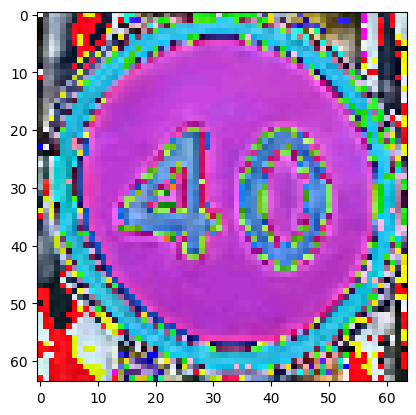

In [146]:
image, label = train_dataset[4]
to_pil = transforms.ToPILImage()
pil_image = to_pil(image)
plt.imshow(pil_image)
plt.show()


In [147]:
for batch_idx, (data, target) in enumerate(train_dataloader):
    # Check the shape and type of the data
    print(f"Batch {batch_idx}:")
    print(f"Data - Shape: {data.shape}, Type: {data.dtype}")
    print(f"Target - Shape: {target.shape}, Type: {target.dtype}")
    if batch_idx == 2:
        break

Batch 0:
Data - Shape: torch.Size([32, 3, 64, 64]), Type: torch.float32
Target - Shape: torch.Size([32, 4]), Type: torch.float32
Batch 1:
Data - Shape: torch.Size([32, 3, 64, 64]), Type: torch.float32
Target - Shape: torch.Size([32, 4]), Type: torch.float32
Batch 2:
Data - Shape: torch.Size([32, 3, 64, 64]), Type: torch.float32
Target - Shape: torch.Size([32, 4]), Type: torch.float32


# Part 2: Training Loop (10 pts)
Create a training loop for the model. The data_loader provides batches of images and their labels. For each batch, we need to:

1. Zero out the gradients of the model
2. Perform a forward pass through the model.
3. Compute the loss using the specified criterion.
4. Perform the backward pass.
5. Update the model parameters using the optimizer.


You will need to keep track of the train and validation losses at each epoch. You need to store them in the `train_loss_arr` and `val_loss_arr` lists. You should accumulate the training loss throughout the epoch. You need to call the provided `val()` function at the end of each epoch to compute the validation loss.


In [148]:
criterion = nn.CrossEntropyLoss()

In [149]:
#----------------------------------------#
# TODO: Implement train in submission.py #
#----------------------------------------#

# Part 3: Create a Convolutional Neural Network (10 pts)
## Part 3.1
We will begin by implementing a simple Convolutional Neural Network without Pooling or extra features.
The base model architecture that you need to implement has the following components:
- **conv1**: convolution layer with 4 output channels, kernel size of 3, stride of 2, padding of 1 (input is a color image)
- **ReLU** nonlinearity
- **conv2**: convolution layer with 16 output channels, kernel size of 3, stride of 2, padding of 1
- **ReLU** nonlinearity
- **conv3**: convolution layer with 32 output channels, kernel size of 3, stride of 2, padding of 1
- **ReLU** nonlinearity
- **fc1**:    fully connected layer with 1024 output features
- **ReLU** nonlinearity
- **fc2**:   fully connected layer with 4 output features (the number of classes)

Hint: Make use of the functions here: https://pytorch.org/docs/stable/nn.html.

**Note that for the relu you should use functional version of ReLU (i.e. F.relu) for the creation of the ConvNet. Also, please follow the names given above for the layer names. This also applies to the rest of the models you will create (ConvNetMaxPooling, ConvNetBN, and ConvNetDropout, ResidualBlock, and ResNet)**

In [150]:
#------------------------------------------#
# TODO: Implement ConvNet in submission.py #
#------------------------------------------#

Use the following test as a sanity check (it only checks the out shape). This test does not guarantee correctness of the full implementation. Feel free to add additional test cases!

In [151]:
def testConvNet():
  net = submission.ConvNet()
  input_tensor = torch.randn(1, 3, 64, 64)
  output = net(input_tensor)
  assert(output.size() ==torch.Size([1, 4]))

testConvNet()

## Part 3.2
Experiment with 3-5 learning rates and plot the performance curves for the different learning rates.

In [152]:
train_loss_results = dict()
val_loss_results = dict()

for learning_rate in [
    1e-2,
    1e-4,
    1e-6,
    1e-8
    # TODO: Add at least two more learning rate settings
]:
  print('-'*20)
  print(f"learning_rate: {learning_rate}")
  model_conv = submission.ConvNet()
  model_conv.to(device)
  optimizer = optim.SGD(model_conv.parameters(), lr=learning_rate, momentum=0.9)
  data_loader = train_dataloader
  epochs = 20
  convnet_train_loss, convnet_val_loss = submission.train(model_conv, data_loader, val_dataloader, criterion, optimizer, epochs, device)
  train_loss_results[learning_rate] = convnet_train_loss
  val_loss_results[learning_rate] = convnet_val_loss


--------------------
learning_rate: 0.01
Epoch: 0, train loss: 1.1767490565776826, validation loss: 0.8933698634306589
Epoch: 1, train loss: 0.8077399849891662, validation loss: 0.7474843064943949
Epoch: 2, train loss: 0.504007538408041, validation loss: 0.4320354213317235
Epoch: 3, train loss: 0.25028417436406014, validation loss: 0.20082937429348627
Epoch: 4, train loss: 0.10447693355381489, validation loss: 0.14099806050459543
Epoch: 5, train loss: 0.07583295989315957, validation loss: 0.15662343761262795
Epoch: 6, train loss: 0.09867640634765848, validation loss: 0.1404381695513924
Epoch: 7, train loss: 0.10805484629236162, validation loss: 0.15147227483491102
Epoch: 8, train loss: 0.08993410324692377, validation loss: 0.07501108571887016
Epoch: 9, train loss: 0.05933784036897123, validation loss: 0.11571449227631092
Epoch: 10, train loss: 0.031501518469303845, validation loss: 0.034479247444930174
Epoch: 11, train loss: 0.01215509506869239, validation loss: 0.026647991631762125
Ep

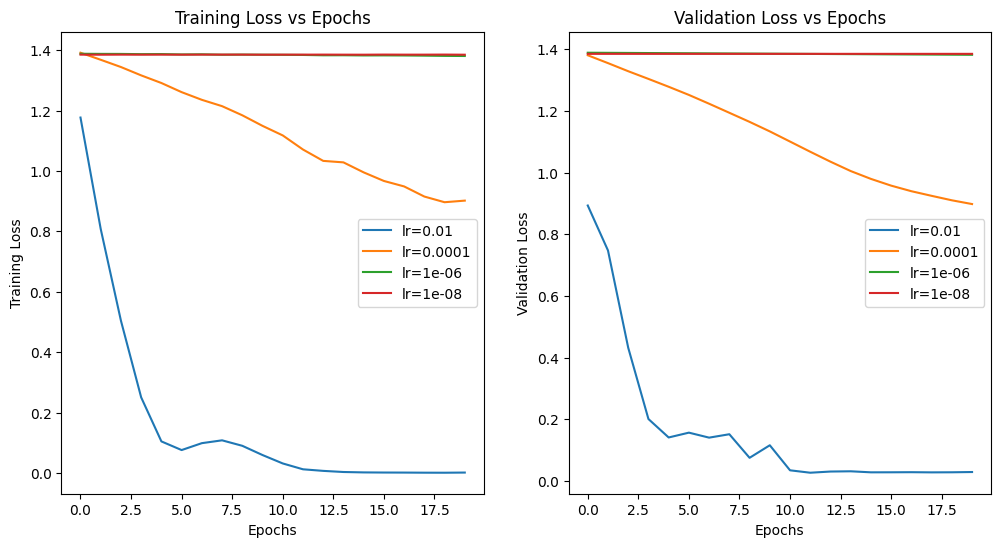

In [153]:
# Plots the training loss and test accuracy curves for different learning rates here

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for learning_rate, loss in train_loss_results.items():
  axs[0].plot(loss, label=f"lr={learning_rate}")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Training Loss")
axs[0].set_title("Training Loss vs Epochs")
axs[0].legend()

for learning_rate, loss in val_loss_results.items():
    axs[1].plot(loss, label=f"lr={learning_rate}")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Validation Loss")
axs[1].set_title("Validation Loss vs Epochs")
axs[1].legend()

plt.show()


### Note down anything you have observed from your experiment (one or two sentences will suffice). Write 2-3 sentences in `responses.tex`.

# Part 4: Add Pooling and Subsampling (5 pts)

Modify your ConvNet implementation by adding max pooling with stride = 2 and kernel = 2 after each convolutional block's ReLU. You might want to use [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html).

Hint: since adding max pooling layers will change the dimensions of the convolution layers' outputs, you will need to modify the input dimensionality of the first fully-connected layer as well.

**NOTE:** You will need to have a separate max-pool layer each time you max-pool so that the autograder can check your network. (This is just an architecture choice. Having one max-pool layer and using it multiple times also works, because the layer doesn't have any parameters to update.) Name the layers ``pool1``, ``pool2``, and ``pool3``.

In [154]:
#----------------------------------------------------#
# TODO: Implement ConvNetMaxPooling in submission.py #
#----------------------------------------------------#

Use the following test as a sanity check. This test does not guarantee correctness of the entire implementation.

In [155]:
def testConvNetMaxPool():
  net = submission.ConvNetMaxPooling()
  input_tensor = torch.randn(1, 3, 64, 64)
  output = net(input_tensor)
  assert(output.size() ==torch.Size([1, 4]))

testConvNetMaxPool()

# Part 5: Implement BatchNorm (17.5 pts)

Here we will implement a custom BatchNorm layer. Refer back to the lecture notes to remind yourself about how batch normalization works.

In [156]:
#-----------------------------------------------------#
# TODO: Implement BatchNormalization in submission.py #
#-----------------------------------------------------#



Use the following test as a sanity check. This test does not guarantee correctness of the entire implementation.

In [157]:
def testBatchNorm():
    torch.manual_seed(42)
    np.random.seed(42)

    # Initialize batchnorm layers
    student_bn = submission.BatchNormalization(num_features=3)
    student_bn.train()
    torch_bn = nn.BatchNorm2d(num_features=3)
    torch_bn.train()

    for i in range(50):
        # Generate random input data
        input_data = np.random.randn(10, 3, 28, 28)
        input_tensor = torch.tensor(input_data, dtype=torch.float32)

        # Forward pass through both layers
        student_output = student_bn.forward(input_tensor)
        torch_output = torch_bn(input_tensor)

        # Convert outputs to numpy arrays for comparison
        student_output_np = student_output.detach().numpy()
        torch_output_np = torch_output.detach().numpy()

        # Check if outputs are close within a tolerance
        assert np.allclose(student_output_np, torch_output_np, atol=1e-3)

    # Generate random input data
    input_data = np.random.randn(10, 3, 28, 28)
    input_tensor = torch.tensor(input_data, dtype=torch.float32)

    # Switch to inference mode
    student_bn.eval()
    torch_bn.eval()

    # Forward pass through both layers
    student_output = student_bn.forward(input_tensor)
    torch_output = torch_bn(input_tensor)

    # Convert outputs to numpy arrays for comparison
    student_output_np = student_output.detach().numpy()
    torch_output_np = torch_output.detach().numpy()

    # Check if outputs are close within a tolerance
    print(np.max(student_output_np-torch_output_np))
    assert np.allclose(student_output_np, torch_output_np, atol=1e-3)

    print("BatchNormalization test passed!")

if __name__ == "__main__":
    testBatchNorm()

2.3841858e-07
BatchNormalization test passed!


Create the `ConvNetBN` model by copying your `ConvNetMaxPooling` model and adding `BatchNormalization` layers after each convolutional layer. Name the layers ``bn1``, ``bn2``, and ``bn3``.

In [158]:
#----------------------------------------------------------------------------#
# TODO: Implemment ConvNetBN to have BatchNorm layers after each convolution #
#----------------------------------------------------------------------------#

# Part 6: Dropout (12.5 pts)
Task: Custom Dropout

Now, you will implement your own custom dropout layer from scratch and compare its performance with PyTorch's built-in dropout layer. Refer back to the lecture notes to remind yourself on what dropout is and how it is a regularization technique.

Recall that the lecture notes discuss dropping out at training time and scaling at inference time. Another way to implement dropout is to both drop out and scale at training time and do nothing at inference time. You should implement dropout in this style.

In [159]:
#------------------------------------------------#
# TODO: Implement CustomDropout in submission.py #
#------------------------------------------------#

Use the following as a sanity check.

In [160]:
# Toy example
class LinearDropout(nn.Module):
    def __init__(self, num_features, dropout=0.1):
        super(LinearDropout, self).__init__()
        self.linear = nn.Linear(num_features, 1)
        # init to all ones
        self.linear.weight.data.fill_(1)
        self.dropout = submission.CustomDropout(dropout)


    def forward(self, x):
        return self.linear(self.dropout(x))

def testDropout():
    torch.manual_seed(42)
    np.random.seed(42)

    # Initialize batchnorm layers
    linear_dropout = LinearDropout(512)

    input_tensor = torch.ones((1, 512), dtype=torch.float32)
    # Expand the input tensor 1000 times
    input_tensor = input_tensor.expand(1000, -1)
    linear_dropout.eval()
    output = linear_dropout(input_tensor)
    print(f'Test mode output mean: {output.mean()}')
    print(f'Test mode output std: {output.std()}')
    # Check if outputs are close within a tolerance
    deterministic_output = output[0]
    assert torch.allclose(output.mean(), deterministic_output, atol=1e-5)
    assert torch.allclose(output.std(), torch.zeros(1), atol=1e-5)


    linear_dropout.train()
    output_list = []
    for i in range(50):
        # accumulate predictions
        output = linear_dropout(input_tensor)
        output_list.append(output)

    output_list = torch.cat(output_list)
    output_mean = output_list.mean()
    print(f'Train mode output mean: {output_mean}')
    print(f'Train mode output std: {output_list.std()}')
    # Check if outputs are close within a tolerance
    assert torch.allclose(output_mean, deterministic_output, atol=1e-1)
    # StDev should be large
    assert output_list.std() > 1

    print("Dropout test passed!")

testDropout()

Test mode output mean: 512.0137329101562
Test mode output std: 0.0
Train mode output mean: 512.0478515625
Train mode output std: 7.542212963104248
Dropout test passed!


Create `ConvNetDropout` by copying your `ConvNetBN` model and modifying it by adding a dropout layer with probability 0.5 after each ReLU.

**NOTE:** You will need to have a separate dropout layer for each of the layers, so that it can pass the autograder. (Like before, this is just an architecture choice. Having one dropout layer and using it multiple times also works and you should convince yourself of this too.) Name these layers ``drop1``, ``drop2``, ``drop3``, and ``drop4``.

In [161]:
#-------------------------------------------------#
# TODO: Implement ConvNetDropout in submission.py #
#-------------------------------------------------#

# Part 7: Create a ResNet (45 pts)





## 7.1: Residual Blocks (35 pts)

We first begin by implementing a residual block. Recall from homework 1 that the difference between a residual block and plain convolutional layers is the identity mapping, which adds the input to the output function.

You will implement a residual block with the following structure:
1.   Two convolutional layers with 3x3 kernels/filters, a stride of `stride`, and padding = 1:

        a. The first convolutional layer
        takes an input with `in_channel` number of channels and returns an output with `interm_channel` number of channels. Name this layer `conv1`.

        b. The second convolutional layer takes an input with `interm_channel` number of channels and returns an output with `out_channel` number of channels. Name this layer `conv2`.

2.   Two batch normalization layers, applied after each convolutional layer. Name these layers `bn1` and `bn2`. Use Pytorch's implementation of BatchNorm2d.
3. A ReLU activation function, applied after the first batch norm.
4. Add a 1x1 convolutional layer (name it ``conv3``) to the residual branch. This layer adjusts the input tensor so that its number of channels matches the number produced by the main branch (``out_channel``). Use a kernel size of 1x1 and the same stride (``stride``) as the main convolutions to guarantee that both the spatial dimensions and channel count align for the subsequent addition.
5. After the elementwise summation of the residual branch (the input tensor adjusted by conv3) and the main branch (output from conv2 after normalization), apply a final ReLU activation function to the resulting tensor.

Here are some Pytorch docs that may be useful:


*   Conv2d: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
*   BatchNorm2d: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
* ReLU: https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html



In [162]:
#------------------------------------------------#
# TODO: Implement ResidualBlock in submission.py #
#------------------------------------------------#

Use the following test as a sense check. It is very basic and does not guarantee correctness.

In [163]:
def test_residual_block():
  in_channel = 9
  interm_channel = 6
  out_channel = 3
  blk = submission.ResidualBlock(in_channel, interm_channel, out_channel)
  X = torch.randn(4, in_channel, 6, 6)

  conv1_out = blk.conv1(X)
  conv2_out = blk.conv2(conv1_out)

  assert conv1_out.shape == torch.Size([4, interm_channel, 6, 6])
  assert conv2_out.shape == torch.Size([4, out_channel, 6, 6])
  assert blk(X).shape == torch.Size([4, out_channel, 6, 6])
  print("Tests passed")

test_residual_block()

Tests passed


## 7.2: ResNet Model (10 pts)

We can now move on to implementing an entire Residual Network. The main portion of a ResNet, as you will implement, simply involves stacking Residual Blocks together. The entire architecture is as follows:

1. The first step is to apply a 7x7 convolution, followed by a batch normalization layer (with activation) and Max Pooling. This step is initialized in `self.first`.

2. Depending on the depth of the network, stack residual blocks together in what is referred to as a "block layer" in this assignment (a more detailed description below, but essentially a stack of blocks with the same number of output channels). This is the part of the ResNet you will be implementing.

3. The output of the residual blocks is average pooled, flattened, then passed into a linear classifier. This step is initialized in `self.last`.

Finish the implementation for a ResNet below, in the following sequence:
1. Implement the function `block_layer`. In this assignment, a `block_layer` just refers to a stack of `num_blocks` blocks that has number of input channels `in_channel` to the first block, and `out_channel` as the number of output channels for all blocks.

  In other words, for simplicity sake (and, as it turns out, what is common in actual ResNets such as the ResNet18), each Residual Block will have the same number of output channels for each convolutional layer (so in this assignment, going back to the ResidualBlock class above, `interm_channel` ==`out_channel`). Use the ResidualBlock class above when implementing the functon `block_layer`.

2. Add 2 block layers to the initialization of the ResNet, each layer with `num_blocks` blocks stacked together.

     a. Block layer 1 would have an input with `layer1_channel` number of channels. Call this layer `layer1`.

     b. Block layer 2 would have an input with `layer2_channel` number of channels and output with `out_channel` number of channels. Call this layer `layer2`.

3. Implement the forward function based on the architecture described above.

Here are some Pytorch docs for functions referenced in the provided implementation below:



*   Sequential: https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
*   LazyConv2d: https://pytorch.org/docs/stable/generated/torch.nn.LazyConv2d.html
* LazyBatchNorm2d: https://pytorch.org/docs/stable/generated/torch.nn.LazyBatchNorm2d.html
* MaxPool2d: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
* AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
* LazyLinear: https://pytorch.org/docs/stable/generated/torch.nn.LazyLinear.html



In [164]:
#-----------------------------------------#
# TODO: Implement ResNet in submission.py #
#-----------------------------------------#

Use the following test as a sense check. It is very basic and does not guarantee correctness.

In [165]:
def test_resnet():
  layer1_channel = 64
  layer2_channel = 128
  out_channel = 256
  num_blocks = 2
  net = submission.ResNet(num_blocks, layer1_channel, layer2_channel, out_channel)
  X = torch.randn(1, 1, 96, 96)

  layer1_out = net.layer1(net.first(X))
  layer2_out = net.layer2(layer1_out)
  net(X)
  assert layer1_out.shape[1] == layer2_channel
  assert layer2_out.shape[1] == out_channel
  assert net(X).shape == torch.Size([1, 4])
  print("Tests passed")

test_resnet()

Tests passed


# Part 8: Comparing the Models (5 pts)

The following cells train the five models you have implemented.



In [166]:
#train ConvNet
model_conv = submission.ConvNet()
model_conv = model_conv.to(device)
optimizer = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
data_loader = train_dataloader
epochs = 40
convnet_train_loss, convnet_val_loss = submission.train(model_conv, data_loader, val_dataloader, criterion, optimizer, epochs, device)

Epoch: 0, train loss: 1.3332515895366668, validation loss: 1.2529736558596294
Epoch: 1, train loss: 1.1672387421131134, validation loss: 1.0607040623823802
Epoch: 2, train loss: 1.0217281430959702, validation loss: 0.9701555669307709
Epoch: 3, train loss: 0.9414591550827026, validation loss: 0.9021380146344503
Epoch: 4, train loss: 0.8568034559488297, validation loss: 0.8443043927351633
Epoch: 5, train loss: 0.7444741517305374, validation loss: 0.7683457235495249
Epoch: 6, train loss: 0.6470898523926735, validation loss: 0.6814211209615072
Epoch: 7, train loss: 0.5300543509423733, validation loss: 0.5796680152416229
Epoch: 8, train loss: 0.4239007070660591, validation loss: 0.46157918373743695
Epoch: 9, train loss: 0.3572970382869244, validation loss: 0.3699858486652374
Epoch: 10, train loss: 0.2898272261023521, validation loss: 0.30735865235328674
Epoch: 11, train loss: 0.24058540239930154, validation loss: 0.2525963559746742
Epoch: 12, train loss: 0.19150677174329758, validation loss

In [167]:
#train ConvNetMaxPooling
model_pool = submission.ConvNetMaxPooling()
model_pool = model_pool.to(device)
optimizer = optim.SGD(model_pool.parameters(), lr=0.001, momentum=0.9)
data_loader = train_dataloader
epochs = 40
convnet_max_pooling_train_loss, convnet_max_pooling_val_loss = submission.train(model_pool, data_loader, val_dataloader, criterion, optimizer, epochs, device)

Epoch: 0, train loss: 1.2945803821086883, validation loss: 1.1362727284431458
Epoch: 1, train loss: 1.015291264653206, validation loss: 0.938205341498057
Epoch: 2, train loss: 0.8780167400836945, validation loss: 0.897102932135264
Epoch: 3, train loss: 0.8534414857625962, validation loss: 0.8855921725432078
Epoch: 4, train loss: 0.8752880692481995, validation loss: 0.8773964742819468
Epoch: 5, train loss: 0.866656705737114, validation loss: 0.8714519838492075
Epoch: 6, train loss: 0.8262404963374138, validation loss: 0.8666717906792959
Epoch: 7, train loss: 0.8533933371305465, validation loss: 0.8612426817417145
Epoch: 8, train loss: 0.8436155140399932, validation loss: 0.8562517464160919
Epoch: 9, train loss: 0.8054879128932952, validation loss: 0.8506849408149719
Epoch: 10, train loss: 0.8148159325122833, validation loss: 0.8421530524889628
Epoch: 11, train loss: 0.8178561687469482, validation loss: 0.8312366902828217
Epoch: 12, train loss: 0.7890379309654236, validation loss: 0.8177

In [168]:
#train ConvNetBN
model_BN = submission.ConvNetBN()
model_BN.to(device)
optimizer = optim.SGD(model_BN.parameters(), lr=0.001, momentum=0.9)
data_loader = train_dataloader
epochs = 40
convnet_bn_train_loss, convnet_bn_val_loss = submission.train(model_BN, data_loader, val_dataloader, criterion, optimizer, epochs, device)

Epoch: 0, train loss: 1.0127550065517426, validation loss: 0.8811708589394888
Epoch: 1, train loss: 0.6273065701127052, validation loss: 0.5520195265611013
Epoch: 2, train loss: 0.42256984412670134, validation loss: 0.41419964532057446
Epoch: 3, train loss: 0.30284218639135363, validation loss: 0.35039835423231125
Epoch: 4, train loss: 0.2376834735274315, validation loss: 0.26279448469479877
Epoch: 5, train loss: 0.2047150157392025, validation loss: 0.21436149378617605
Epoch: 6, train loss: 0.17205025553703307, validation loss: 0.19602899501721063
Epoch: 7, train loss: 0.1361497277393937, validation loss: 0.1753507343431314
Epoch: 8, train loss: 0.11967244595289231, validation loss: 0.161501324425141
Epoch: 9, train loss: 0.10539256641641259, validation loss: 0.15322338913877806
Epoch: 10, train loss: 0.09427270647138357, validation loss: 0.14971915384133658
Epoch: 11, train loss: 0.1010272553190589, validation loss: 0.13429897526899973
Epoch: 12, train loss: 0.08582690497860312, valid

In [169]:
#train ConvNetDropout
model_dropout = submission.ConvNetDropout()
model_dropout.to(device)
optimizer = optim.SGD(model_dropout.parameters(), lr=0.001, momentum=0.9)
data_loader = train_dataloader
epochs = 40
convnet_dropout_train_loss, convnet_dropout_val_loss = submission.train(model_dropout, data_loader, val_dataloader, criterion, optimizer, epochs, device)

Epoch: 0, train loss: 1.0600697875022889, validation loss: 1.0622175534566243
Epoch: 1, train loss: 0.755130210518837, validation loss: 0.8510261078675588
Epoch: 2, train loss: 0.6979060634970665, validation loss: 0.7971901496251425
Epoch: 3, train loss: 0.5642670162022114, validation loss: 0.7457559903462728
Epoch: 4, train loss: 0.5747895866632462, validation loss: 0.7294163008530935
Epoch: 5, train loss: 0.5072844207286835, validation loss: 0.7365483144919077
Epoch: 6, train loss: 0.43587696105241774, validation loss: 0.7050720949967703
Epoch: 7, train loss: 0.4129871718585491, validation loss: 0.665643443663915
Epoch: 8, train loss: 0.3941922076046467, validation loss: 0.6660782247781754
Epoch: 9, train loss: 0.3583960995078087, validation loss: 0.7104480067888895
Epoch: 10, train loss: 0.37192627489566804, validation loss: 0.6657798786958059
Epoch: 11, train loss: 0.39884117171168326, validation loss: 0.6723191887140274
Epoch: 12, train loss: 0.333640792965889, validation loss: 0.

In [170]:
#train resnet
layer1_channel = 12
layer2_channel = 64
out_channel = 128
num_blocks = 2
model_res = submission.ResNet(num_blocks, layer1_channel, layer2_channel, out_channel)
model_res.to(device)
optimizer = optim.SGD(model_res.parameters(), lr=0.001, momentum=0.9)
data_loader = train_dataloader
epochs = 40
resnet_train_loss, resnet_val_loss = submission.train(model_res, data_loader, val_dataloader, criterion, optimizer, epochs, device)

Epoch: 0, train loss: 1.0561647489666939, validation loss: 0.9899603426456451
Epoch: 1, train loss: 0.5136530727148056, validation loss: 0.47790474196275073
Epoch: 2, train loss: 0.36550597473978996, validation loss: 0.3172598307331403
Epoch: 3, train loss: 0.28092261105775834, validation loss: 0.24586042016744614
Epoch: 4, train loss: 0.21052398309111595, validation loss: 0.20629210770130157
Epoch: 5, train loss: 0.18437840454280377, validation loss: 0.2203942189613978
Epoch: 6, train loss: 0.140963676571846, validation loss: 0.14087169617414474
Epoch: 7, train loss: 0.12683902755379678, validation loss: 0.1143396074573199
Epoch: 8, train loss: 0.09604998026043177, validation loss: 0.12543997541069984
Epoch: 9, train loss: 0.13677609153091908, validation loss: 0.12451973867913087
Epoch: 10, train loss: 0.14237399939447642, validation loss: 0.12329362084468205
Epoch: 11, train loss: 0.09453837368637323, validation loss: 0.13909161711732546
Epoch: 12, train loss: 0.07871712949126959, va

Now run the cell below to compare the training losses at each epoch for each of the three models above.

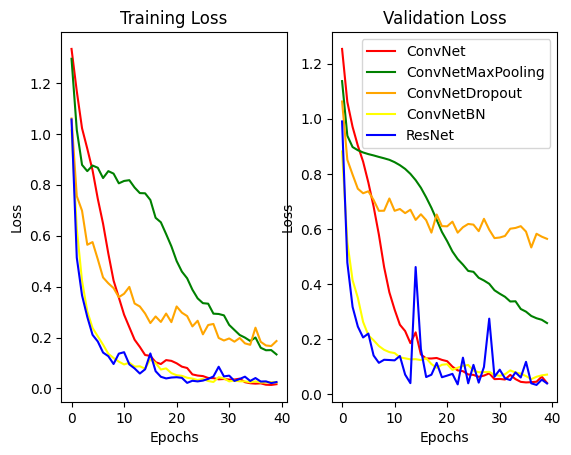

In [171]:
x = [epoch for epoch in range(epochs)]

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x,convnet_train_loss, color='red',label='ConvNet')
ax1.plot(x,convnet_max_pooling_train_loss, color='green',label='ConvNetMaxPooling')
ax1.plot(x,convnet_bn_train_loss, color='yellow',label='ConvNetBN')
ax1.plot(x,convnet_dropout_train_loss, color='orange',label='ConvNetDropout')
ax1.plot(x,resnet_train_loss, color='blue', label='ResNet')

ax1.set_title("Training Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(x,convnet_val_loss, color='red',label='ConvNet')
ax2.plot(x,convnet_max_pooling_val_loss, color='green',label='ConvNetMaxPooling')
ax2.plot(x,convnet_dropout_val_loss, color='orange',label='ConvNetDropout')
ax2.plot(x,convnet_bn_val_loss, color='yellow',label='ConvNetBN')

ax2.plot(x,resnet_val_loss, color='blue', label='ResNet')

ax2.set_title("Validation Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")

plt.legend()
plt.show()


### Q: What do you notice about the graphs above and the differences between the five models you have implemented? Write 2-3 sentences in ``responses.tex``.

In [172]:
model_res.eval()
# -------------------------------
# Generate predictions on the test set
# -------------------------------
predictions = []

with torch.no_grad():
    for data in test_dataloader:
        data = data.to(device)
        output = model_res(data)
        preds = output.argmax(dim=1)
        predictions.extend(preds.cpu().numpy().tolist())

# -------------------------------
# Save the predictions to a CSV file
# -------------------------------
pred_df = pd.DataFrame(predictions, columns=["preds"])
file_save_path = os.path.join(base_dir, "resnet_preds.csv")
pred_df.to_csv(file_save_path, index=False)

print("Predictions saved to 'resnet_preds.csv'")

Predictions saved to 'resnet_preds.csv'


# Once finished, upload `submission.py` and `resnet_preds.csv` to  [***Coding Assignment 1***](https://www.gradescope.com/courses/1245650); do not change the filenames. Upload a PDF of your written responses to [***Coding Assignment 1 Written Responses***](https://www.gradescope.com/courses/1245650).